In this part I tried to train a scratch model on the multiscale data but it failed to give good results on the validation set. The convergence speed is slow and the model has a poor precision. It shows that InceptionV3 might a better choice than trying something from scratch.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from openslide import open_slide, __library_version__ as openslide_version
import time
import os
import random
import pathlib, shutil
from PIL import Image
from skimage.color import rgb2gray
from google.colab import drive
import keras
import sklearn
from sklearn.metrics import roc_curve, confusion_matrix, plot_confusion_matrix
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Input, Convolution2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'storied-smile-311319'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://augmented_patches/
gs://hw4_xh2465/
gs://slices-xh2465/
gs://slides_xh2465/


In [ ]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Mounted at /gdrive


In [ ]:
numbers = ['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059', 
          '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']
train_slides = numbers[:13]
val_slides = numbers[13:17]
test_slides = numbers[17:]

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))
 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
def random_display(df, n):
    for i in range(n):
        idx = random.choice(df.index)
        for column in df.columns[:-1]:
            print(column)
            path = df.loc[idx, column]
            img = tf.io.read_file(path)  # read
            img = tf.image.decode_jpeg(img, channels=3)  # decode
            plt.imshow(img) # plot the image
            plt.show()
        print('label: ', df.loc[idx, 'label'])
        print()

In [ ]:
colab_root = "/content/"

In [ ]:
train_df_path = os.path.join(colab_root, "train_df.csv")
download_if_missing("https://storage.googleapis.com/augmented_patches/multiscale_level3to5/train_df.csv", 
                    train_df_path)

9150464/9149817 [==============================] - 0s 0us/step


'/content/train_df.csv'

In [ ]:
val_df_path = os.path.join(colab_root, "val_df.csv")
download_if_missing("https://storage.googleapis.com/augmented_patches/multiscale_level3to5/val_df.csv", 
                    val_df_path)

2490368/2485282 [==============================] - 0s 0us/step


'/content/val_df.csv'

In [ ]:
test_df_path = os.path.join(colab_root, "test_df.csv")
download_if_missing("https://storage.googleapis.com/augmented_patches/multiscale_level3to5/test_df.csv", 
                    test_df_path)

3014656/3010150 [==============================] - 0s 0us/step


'/content/test_df.csv'

In [ ]:
data_zip_path = os.path.join(colab_root, "augmented_data.zip")
download_if_missing("https://storage.googleapis.com/augmented_patches/multiscale_level3to5/augmented_data.zip", 
                    data_zip_path)

5178032128/5178028657 [==============================] - 55s 0us/step


'/content/augmented_data.zip'

In [ ]:
data_root = os.path.join(colab_root, 'data/')
!unzip -q $data_zip_path -d $data_root

In [ ]:
!du -sh $data_root

5.6G	/content/data/


In [ ]:
train_df = pd.read_csv(train_df_path, index_col=0)
val_df = pd.read_csv(val_df_path, index_col=0)
test_df = pd.read_csv(test_df_path, index_col=0)

In [ ]:
train_df.head()

,image_level3,image_level4,image_level5,label
0,/content/data/tumor_001/3/0_0.jpg,/content/data/tumor_001/4/-149_-149.jpg,/content/data/tumor_001/5/-448_-448.jpg,0
1,/content/data/tumor_001/3/128_0.jpg,/content/data/tumor_001/4/-21_-149.jpg,/content/data/tumor_001/5/-320_-448.jpg,0
2,/content/data/tumor_001/3/256_0.jpg,/content/data/tumor_001/4/107_-149.jpg,/content/data/tumor_001/5/-192_-448.jpg,0
3,/content/data/tumor_001/3/384_0.jpg,/content/data/tumor_001/4/235_-149.jpg,/content/data/tumor_001/5/-64_-448.jpg,0
4,/content/data/tumor_001/3/512_0.jpg,/content/data/tumor_001/4/363_-149.jpg,/content/data/tumor_001/5/64_-448.jpg,0


In [ ]:
val_df.head()

,image_level3,image_level4,image_level5,label
0,/content/data/tumor_078/3/0_0.jpg,/content/data/tumor_078/4/-149_-149.jpg,/content/data/tumor_078/5/-448_-448.jpg,0
1,/content/data/tumor_078/3/128_0.jpg,/content/data/tumor_078/4/-21_-149.jpg,/content/data/tumor_078/5/-320_-448.jpg,0
2,/content/data/tumor_078/3/256_0.jpg,/content/data/tumor_078/4/107_-149.jpg,/content/data/tumor_078/5/-192_-448.jpg,0
3,/content/data/tumor_078/3/384_0.jpg,/content/data/tumor_078/4/235_-149.jpg,/content/data/tumor_078/5/-64_-448.jpg,0
4,/content/data/tumor_078/3/512_0.jpg,/content/data/tumor_078/4/363_-149.jpg,/content/data/tumor_078/5/64_-448.jpg,0


In [ ]:
test_df.head()

,image_level3,image_level4,image_level5,label
0,/content/data/tumor_094/3/128_0.jpg,/content/data/tumor_094/4/-21_-149.jpg,/content/data/tumor_094/5/-320_-448.jpg,0
1,/content/data/tumor_094/3/256_0.jpg,/content/data/tumor_094/4/107_-149.jpg,/content/data/tumor_094/5/-192_-448.jpg,0
2,/content/data/tumor_094/3/384_0.jpg,/content/data/tumor_094/4/235_-149.jpg,/content/data/tumor_094/5/-64_-448.jpg,0
3,/content/data/tumor_094/3/512_0.jpg,/content/data/tumor_094/4/363_-149.jpg,/content/data/tumor_094/5/64_-448.jpg,0
4,/content/data/tumor_094/3/896_0.jpg,/content/data/tumor_094/4/747_-149.jpg,/content/data/tumor_094/5/448_-448.jpg,0


In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(71209, 4)
(19606, 4)
(23606, 4)


In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
image1_train = np.array(train_df.iloc[:, 0].values)
image2_train = np.array(train_df.iloc[:, 1].values)
image3_train = np.array(train_df.iloc[:, 2].values)
label_train = np.array(train_df.iloc[:, 3].values)

In [ ]:
bool_train_labels = np.array(label_train) != 0.0

In [ ]:
image1_train_pos = image1_train[bool_train_labels]
image1_train_neg = image1_train[~bool_train_labels]
image2_train_pos = image2_train[bool_train_labels]
image2_train_neg = image2_train[~bool_train_labels]
image3_train_pos = image3_train[bool_train_labels]
image3_train_neg = image3_train[~bool_train_labels]

label_train_pos = label_train[bool_train_labels]
label_train_neg = label_train[~bool_train_labels]

In [ ]:
image1_train_pos[:5]

array(['/content/data/tumor_016/3/4352_19840.jpg',
       '/content/data/tumor_016/3/4608_18688.jpg',
       '/content/data/tumor_031/3/7296_20736.jpg',
       '/content/data/tumor_075/3/4096_6656.jpg',
       '/content/data/tumor_064/3/2048_19840.jpg'], dtype=object)

In [ ]:
image2_train_pos[:5]

array(['/content/data/tumor_016/4/4203_19691.jpg',
       '/content/data/tumor_016/4/4459_18539.jpg',
       '/content/data/tumor_031/4/7147_20587.jpg',
       '/content/data/tumor_075/4/3947_6507.jpg',
       '/content/data/tumor_064/4/1899_19691.jpg'], dtype=object)

In [ ]:
label_train_pos[:5]

array([1, 1, 1, 1, 1])

In [ ]:
label_train_neg[:5]

array([0, 0, 0, 0, 0])

In [ ]:
image1_val = list(val_df.iloc[:, 0].values)
image2_val = list(val_df.iloc[:, 1].values)
image3_val = list(val_df.iloc[:, 2].values)
label_val = list(val_df.iloc[:, 3].values)

In [ ]:
image1_test = list(test_df.iloc[:, 0].values)
image2_test = list(test_df.iloc[:, 1].values)
image3_test = list(test_df.iloc[:, 2].values)
label_test = list(test_df.iloc[:, 3].values)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 299

In [ ]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)  # read
    img = tf.image.decode_jpeg(img, channels=3)  # decode
    img = tf.cast(img, dtype=tf.float32)
    img /= 255.0  # normalize pixels to 0,1
    return img

In [ ]:
def load_img(img1_path, img2_path, img3_path, label):
  img1 = load_and_preprocess_image(img1_path)
  img2 = load_and_preprocess_image(img2_path)
  img3 = load_and_preprocess_image(img3_path)
  return img1, img2, img3, tf.cast(label, dtype=tf.float32)

In [ ]:
def generate_images(img1, img2, img3, rot, flip, label):
    img1 = tf.image.rot90(img1, rot) 
    img2 = tf.image.rot90(img2, rot) 
    img3 = tf.image.rot90(img3, rot) 
    if flip == 1:
        img1 = tf.image.flip_left_right(img1)
        img2 = tf.image.flip_left_right(img2)
        img3 = tf.image.flip_left_right(img3)

    seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
    img1 = tf.image.stateless_random_brightness(img1, max_delta=64./255, seed=seed)
    img2 = tf.image.stateless_random_brightness(img2, max_delta=64./255, seed=seed)
    img3 = tf.image.stateless_random_brightness(img3, max_delta=64./255, seed=seed)

    seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
    img1 = tf.image.stateless_random_hue(img1, max_delta=0.04, seed=seed)
    img2 = tf.image.stateless_random_hue(img2, max_delta=0.04, seed=seed)
    img3 = tf.image.stateless_random_hue(img3, max_delta=0.04, seed=seed)

    seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
    img1 = tf.image.stateless_random_saturation(img1, lower=0.25, upper=1, seed=seed)
    img2 = tf.image.stateless_random_saturation(img2, lower=0.25, upper=1, seed=seed)
    img3 = tf.image.stateless_random_saturation(img3, lower=0.25, upper=1, seed=seed)

    seed = tf.random.uniform(shape=[2], dtype=tf.int64, maxval=1000000, seed=42)
    img1 = tf.image.stateless_random_contrast(img1, lower=0.25, upper=1, seed=seed)
    img2 = tf.image.stateless_random_contrast(img2, lower=0.25, upper=1, seed=seed)
    img3 = tf.image.stateless_random_contrast(img3, lower=0.25, upper=1, seed=seed)

    img1 = tf.clip_by_value(img1, 0, 1)
    img2 = tf.clip_by_value(img2, 0, 1)
    img3 = tf.clip_by_value(img3, 0, 1)

    return img1, img2, img3, label

In [ ]:
def create_dataset(img1_path, img2_path, img3_path, label, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((img1_path, img2_path, img3_path, label))
    ds = dataset.map(lambda x, y, z, w: tf.numpy_function(
        load_img, [x, y, z, w], [tf.float32, tf.float32, tf.float32, tf.float32]),
        num_parallel_calls=AUTOTUNE)
    final_ds = []

    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE)

    if augment:
        for rot in range(4):
            for flip in range(2):
                curr_ds = ds.map(lambda x, y, z, w: tf.numpy_function(
        generate_images, [x, y, z, rot, flip, w], [tf.float32, tf.float32, tf.float32, tf.float32]),
        num_parallel_calls=AUTOTUNE)
                final_ds.append(curr_ds)

    else:
        final_ds = ds

    return final_ds

In [ ]:
train_pos_ds_list = create_dataset(image1_train_pos, 
                                   image2_train_pos, 
                                   image3_train_pos, 
                                   label_train_pos, 
                                   shuffle=True, 
                                   augment=True)

train_neg_ds_list = create_dataset(image1_train_neg, 
                                   image2_train_neg, 
                                   image3_train_neg, 
                                   label_train_neg, 
                                   shuffle=True, 
                                   augment=True)

val_ds = create_dataset(image1_val, image2_val, image3_val, label_val)
test_ds = create_dataset(image1_test, image2_test, image3_test, label_test)

In [ ]:
print('Number of tumor patches in the training set: ', 
      tf.data.experimental.cardinality(train_pos_ds_list[0]).numpy())
print('Number of normal patches in the training set: ', 
      tf.data.experimental.cardinality(train_neg_ds_list[0]).numpy())

Number of tumor patches in the training set:  924
Number of normal patches in the training set:  70285


In [ ]:
train_pos_ds = train_pos_ds_list[0]
for ds in train_pos_ds_list[1:]:
    train_pos_ds = train_pos_ds.concatenate(ds)

train_neg_ds = train_neg_ds_list[0]
for ds in train_neg_ds_list[1:]:
    train_neg_ds = train_neg_ds.concatenate(ds)

In [ ]:
print('Number of tumor patches after rotation and flip: ',
      tf.data.experimental.cardinality(train_pos_ds).numpy())
print('Number of normal patches after rotation and flip: ',
      tf.data.experimental.cardinality(train_neg_ds).numpy())

Number of tumor patches after rotation and flip:  7392
Number of normal patches after rotation and flip:  562280


In [ ]:
my_iterator = iter(train_pos_ds.batch(BATCH_SIZE))
image1_batch, image2_batch, image3_batch, label_batch = next(my_iterator)

print(image1_batch.shape, 
      image2_batch.shape, 
      image3_batch.shape, 
      label_batch.shape)

print(label_batch)

(32, 299, 299, 3) (32, 299, 299, 3) (32, 299, 299, 3) (32,)
tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.], shape=(32,), dtype=float32)


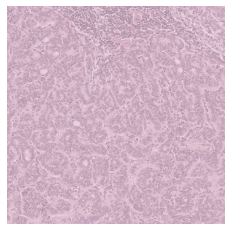

level 3



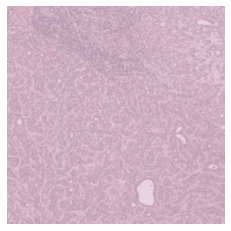

level 4



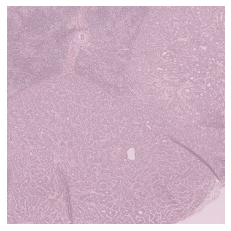

level 5



In [ ]:
for i in range(1):
    plt.imshow(image1_batch[i].numpy())
    plt.axis("off")
    plt.show()
    print('level 3')
    print()

    plt.imshow(image2_batch[i].numpy())
    plt.axis("off")
    plt.show()
    print('level 4')
    print()

    plt.imshow(image3_batch[i].numpy())
    plt.axis("off")
    plt.show()
    print('level 5')
    print()

In [ ]:
my_iterator = iter(train_neg_ds.batch(BATCH_SIZE))
image1_batch, image2_batch, image3_batch, label_batch = next(my_iterator)

print(image1_batch.shape, 
      image2_batch.shape, 
      image3_batch.shape, 
      label_batch.shape)

print(label_batch)

(32, 299, 299, 3) (32, 299, 299, 3) (32, 299, 299, 3) (32,)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(32,), dtype=float32)


In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([train_pos_ds, train_neg_ds], 
                                weights=[0.5, 0.5])

In [ ]:
my_iterator = iter(resampled_ds.batch(BATCH_SIZE))
image1_batch, image2_batch, image3_batch, label_batch = next(my_iterator)

print(image1_batch.shape, 
      image2_batch.shape, 
      image3_batch.shape, 
      label_batch.shape)

print(label_batch)

(32, 299, 299, 3) (32, 299, 299, 3) (32, 299, 299, 3) (32,)
tf.Tensor(
[1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 0.], shape=(32,), dtype=float32)


Label:  tf.Tensor(0.0, shape=(), dtype=float32)



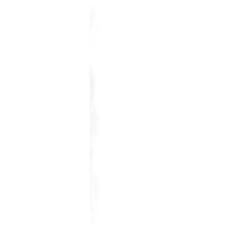

level 3



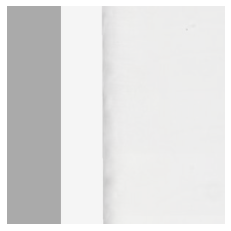

level 4



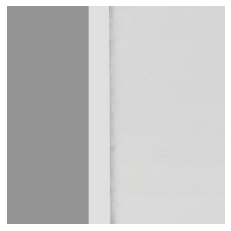

level 5

Label:  tf.Tensor(0.0, shape=(), dtype=float32)



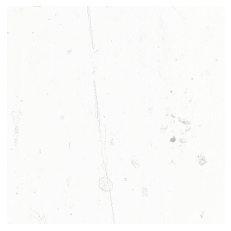

level 3



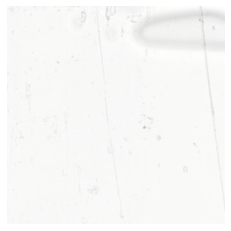

level 4



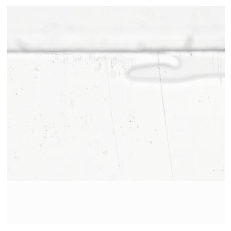

level 5

Label:  tf.Tensor(1.0, shape=(), dtype=float32)



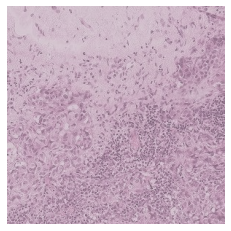

level 3



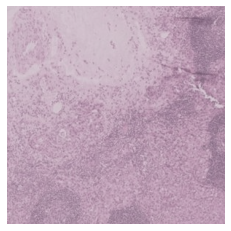

level 4



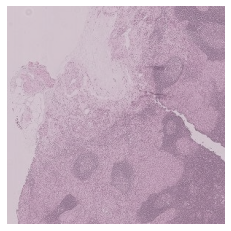

level 5

Label:  tf.Tensor(1.0, shape=(), dtype=float32)



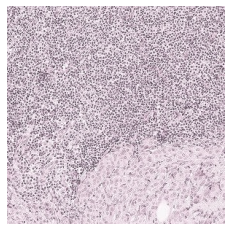

level 3



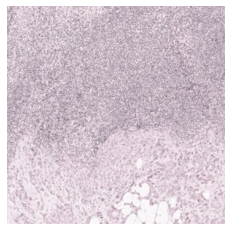

level 4



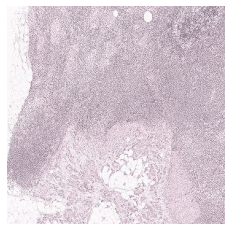

level 5

Label:  tf.Tensor(0.0, shape=(), dtype=float32)



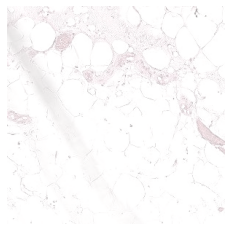

level 3



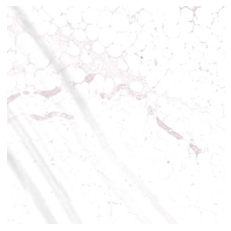

level 4



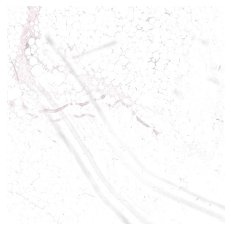

level 5

Label:  tf.Tensor(1.0, shape=(), dtype=float32)



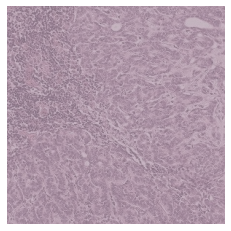

level 3



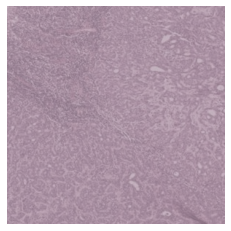

level 4



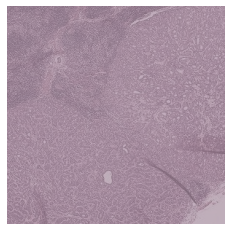

level 5

Label:  tf.Tensor(0.0, shape=(), dtype=float32)



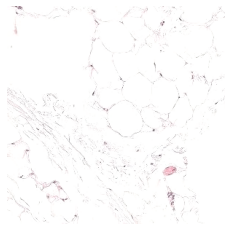

level 3



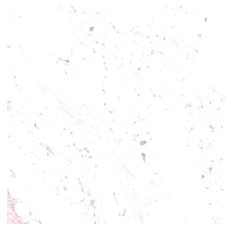

level 4



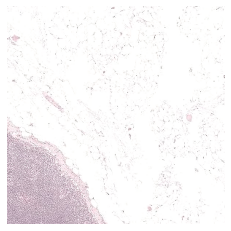

level 5

Label:  tf.Tensor(1.0, shape=(), dtype=float32)



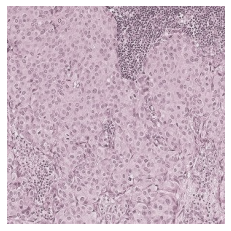

level 3



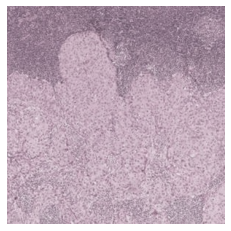

level 4



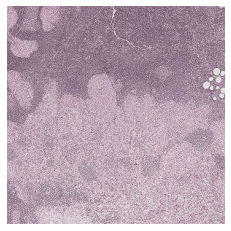

level 5

Label:  tf.Tensor(0.0, shape=(), dtype=float32)



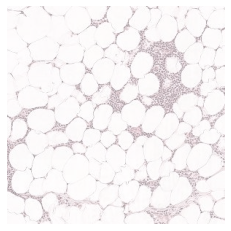

level 3



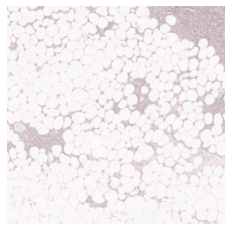

level 4



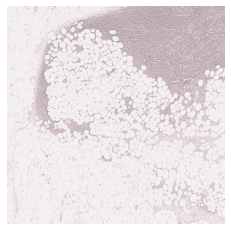

level 5

Label:  tf.Tensor(0.0, shape=(), dtype=float32)



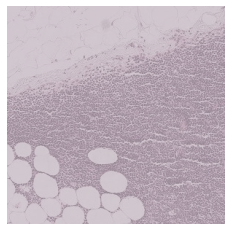

level 3



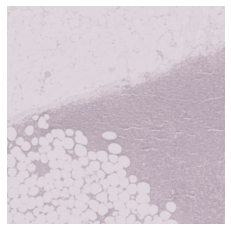

level 4



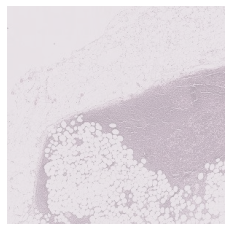

level 5



In [ ]:
for i in range(20, 30):
    print('Label: ', label_batch[i])
    print()
    plt.imshow(image1_batch[i].numpy())
    plt.axis("off")
    plt.show()
    print('level 3')
    print()

    plt.imshow(image2_batch[i].numpy())
    plt.axis("off")
    plt.show()
    print('level 4')
    print()

    plt.imshow(image3_batch[i].numpy())
    plt.axis("off")
    plt.show()
    print('level 5')
    print()

In [ ]:
image1_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image1')

image1_layer = Sequential(name='CNN1')
image1_layer.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
image1_layer.add(layers.MaxPooling2D((2, 2)))
image1_layer.add(layers.Conv2D(32, (3, 3), activation='relu'))
image1_layer.add(layers.MaxPooling2D((2, 2)))
image1_layer.add(layers.Conv2D(64, (3, 3), activation='relu'))
image1_layer.add(layers.MaxPooling2D((2, 2)))
image1_layer.add(layers.Conv2D(128, (3, 3), activation='relu'))
image1_layer.add(layers.MaxPooling2D((2, 2)))
image1_layer.add(layers.GlobalAveragePooling2D())
encoded_image1 = image1_layer(image1_input) 

image2_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype='float32', name='image2')
image2_layer = Sequential(name='CNN2')
image2_layer.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
image2_layer.add(layers.MaxPooling2D((2, 2)))
image2_layer.add(layers.Conv2D(32, (3, 3), activation='relu'))
image2_layer.add(layers.MaxPooling2D((2, 2)))
image2_layer.add(layers.Conv2D(64, (3, 3), activation='relu'))
image2_layer.add(layers.MaxPooling2D((2, 2)))
image2_layer.add(layers.Conv2D(128, (3, 3), activation='relu'))
image2_layer.add(layers.MaxPooling2D((2, 2)))
image2_layer.add(layers.GlobalAveragePooling2D())
encoded_image2 = image2_layer(image2_input) 

image3_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype='float32', name='image3')
image3_layer = Sequential(name='CNN3')
image3_layer.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
image3_layer.add(layers.MaxPooling2D((2, 2)))
image3_layer.add(layers.Conv2D(32, (3, 3), activation='relu'))
image3_layer.add(layers.MaxPooling2D((2, 2)))
image3_layer.add(layers.Conv2D(64, (3, 3), activation='relu'))
image3_layer.add(layers.MaxPooling2D((2, 2)))
image3_layer.add(layers.Conv2D(128, (3, 3), activation='relu'))
image3_layer.add(layers.MaxPooling2D((2, 2)))
image3_layer.add(layers.GlobalAveragePooling2D())
encoded_image3 = image3_layer(image3_input) 

merged = layers.concatenate([encoded_image1, encoded_image2, encoded_image3])
merged = layers.Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[image1_input, image2_input, image3_input], outputs=output)

In [ ]:
model.summary()

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')# precision-recall curve
]

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=METRICS)

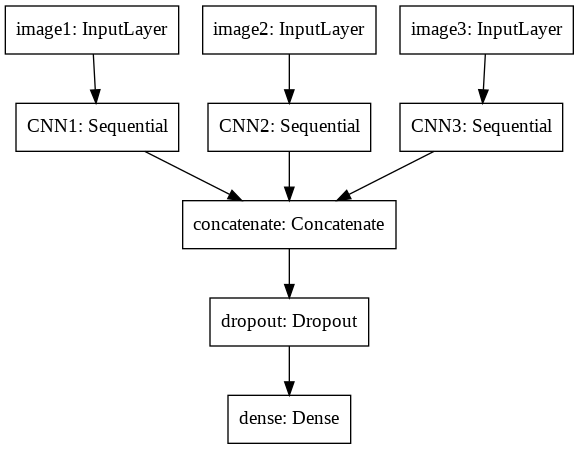

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
metrics_array = []
for i in range(200):
    metrics = model.train_on_batch(x={'image1': image1_batch, 
                                      'image2': image2_batch, 
                                      'image3': image3_batch}, 
                                      y=label_batch)
    metrics_array.append(metrics) 
metrics_array = np.array(metrics_array)

In [ ]:
pred = model.predict(x={'image1': image1_batch, 
                'image2': image2_batch, 
                'image3': image3_batch}).reshape(-1)

In [ ]:
pred_batch = np.array([1 if p > 0.5 else 0 for p in pred])

In [ ]:
def plot_cm(pred, label, p=0.5):
    cm = confusion_matrix(label, pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
def plot_roc(pred, label):
    fpr, tpr, threshold = roc_curve(label, pred)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
metrics_name = ['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc']

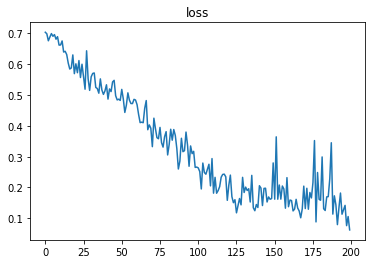

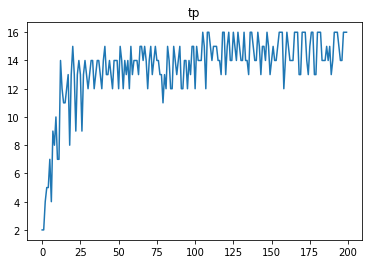

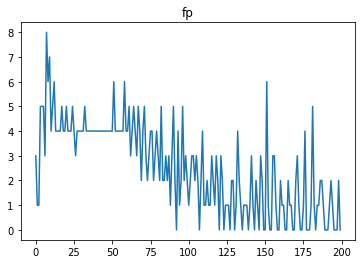

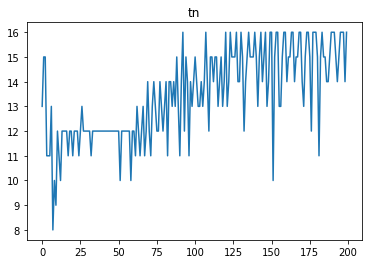

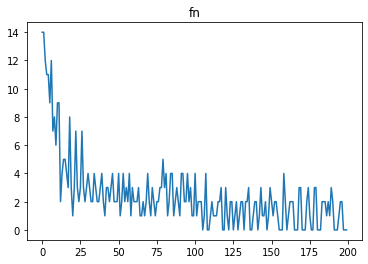

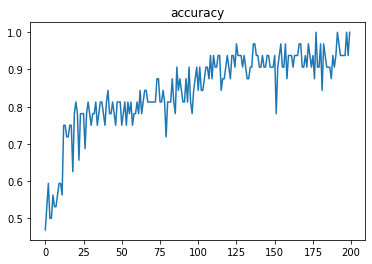

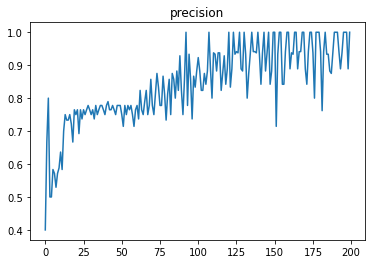

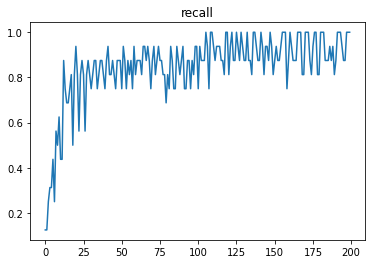

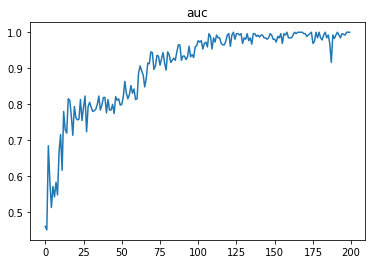

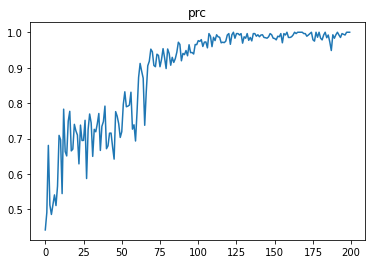

In [ ]:
for i in range(len(metrics_name)):
    plt.plot(metrics_array[:, i])
    plt.title(metrics_name[i])
    plt.show()

Legitimate Transactions Detected (True Negatives):  15
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  16
Total Fraudulent Transactions:  16


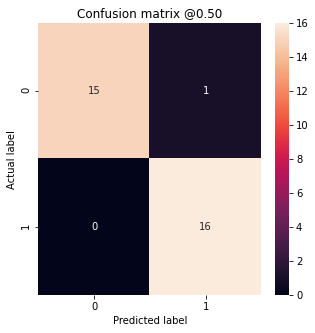

In [ ]:
plot_cm(pred_batch, label_batch)

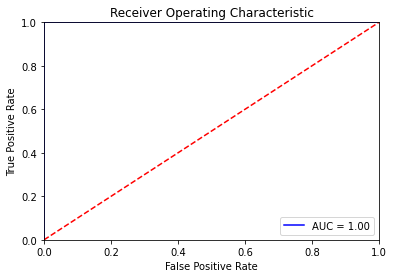

In [ ]:
plot_roc(pred, label_batch)

In [ ]:
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "project")
checkpoint_dir = os.path.join(checkpoint_dir, "Multiscale_from_scratch")
# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [ ]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/checkpoints/project/Multiscale_from_scratch
Checkpoints folder already exists


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


In [ ]:
train_ds = resampled_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
resampled_ds

<_DirectedInterleaveDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [ ]:
val_ds

<BatchDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [ ]:
train_loss = keras.metrics.Mean(name='loss')
train_tp = keras.metrics.TruePositives(name='tp')
train_fp = keras.metrics.FalsePositives(name='fp')
train_tn = keras.metrics.TrueNegatives(name='tn')
train_fn = keras.metrics.FalseNegatives(name='fn')
train_accuracy = keras.metrics.BinaryAccuracy(name='accuracy')
train_precision = keras.metrics.Precision(name='precision')
train_recall = keras.metrics.Recall(name='recall')
train_auc = keras.metrics.AUC(name='auc')
train_prc = keras.metrics.AUC(name='prc', curve='PR')

val_loss = keras.metrics.Mean(name='val_loss')
val_tp = keras.metrics.TruePositives(name='val_tp')
val_fp = keras.metrics.FalsePositives(name='val_fp')
val_tn = keras.metrics.TrueNegatives(name='val_tn')
val_fn = keras.metrics.FalseNegatives(name='val_fn')
val_accuracy = keras.metrics.BinaryAccuracy(name='val_accuracy')
val_precision = keras.metrics.Precision(name='val_precision')
val_recall = keras.metrics.Recall(name='val_recall')
val_auc = keras.metrics.AUC(name='val_auc')
val_prc = keras.metrics.AUC(name='val_prc', curve='PR')

In [ ]:
def evaluate(max_steps=None):
  steps = 0
  for image1_batch, image2_batch, image3_batch, label_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[image1_batch, image2_batch, image3_batch])
    steps += 1 

    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_tp(label_batch, predictions)
    val_fp(label_batch, predictions)
    val_tn(label_batch, predictions)
    val_fn(label_batch, predictions)
    val_accuracy(label_batch, predictions)
    val_precision(label_batch, predictions)
    val_recall(label_batch, predictions)
    val_auc(label_batch, predictions)
    val_prc(label_batch, predictions)

In [ ]:
steps_per_epoch = 100

In [ ]:
train_loss_history = []
train_tp_history = []
train_fp_history = []
train_tn_history = []
train_fn_history = []
train_accuracy_history = []
train_precision_history = []
train_recall_history = []
train_auc_history = []
train_prc_history = []

val_loss_history = []
val_tp_history = []
val_fp_history = []
val_tn_history = []
val_fn_history = []
val_accuracy_history = []
val_precision_history = []
val_recall_history = []
val_auc_history = []
val_prc_history = []

epochs = 20

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    step = 0
    for image1_batch, image2_batch, image3_batch, label_batch in train_ds:
        if step == steps_per_epoch:
            break
        step += 1 
        result = model.train_on_batch(x=[image1_batch, image2_batch, image3_batch], y=label_batch)
        predictions = model.predict(x=[image1_batch, image2_batch, image3_batch])
        # Record metrics after each batch
        train_loss(label_batch, predictions)
        train_tp(label_batch, predictions)
        train_fp(label_batch, predictions)
        train_tn(label_batch, predictions)
        train_fn(label_batch, predictions)
        train_accuracy(label_batch, predictions)
        train_precision(label_batch, predictions)
        train_recall(label_batch, predictions)
        train_auc(label_batch, predictions)
        train_prc(label_batch, predictions)

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Auc: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, Val Auc: {:.2f}, Val Precision: {:.2f}, Val Recall: {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                        train_auc.result(),
                        train_precision.result(),
                        train_recall.result(),
                        val_auc.result(),
                        val_precision.result(),
                        val_recall.result(),
                        time.time() - start))

    train_loss_history.append(train_loss.result())
    train_tp_history.append(train_tp.result())
    train_fp_history.append(train_fp.result())
    train_tn_history.append(train_tn.result())
    train_fn_history.append(train_fn.result())
    train_accuracy_history.append(train_accuracy.result())
    train_precision_history.append(train_precision.result())
    train_recall_history.append(train_recall.result())
    train_auc_history.append(train_auc.result())
    train_prc_history.append(train_prc.result())

    val_loss_history.append(val_loss.result())
    val_tp_history.append(val_tp.result())
    val_fp_history.append(val_fp.result())
    val_tn_history.append(val_tn.result())
    val_fn_history.append(val_fn.result())
    val_accuracy_history.append(val_accuracy.result())
    val_precision_history.append(val_precision.result())
    val_recall_history.append(val_recall.result())
    val_auc_history.append(val_auc.result())
    val_prc_history.append(val_prc.result())

    train_loss.reset_states()
    train_tp.reset_states()
    train_fp.reset_states()
    train_tn.reset_states()
    train_fn.reset_states()
    train_accuracy.reset_states()
    train_precision.reset_states()
    train_recall.reset_states()
    train_auc.reset_states()
    train_prc.reset_states()

    val_loss.reset_states()
    val_tp.reset_states()
    val_fp.reset_states()
    val_tn.reset_states()
    val_fn.reset_states()
    val_accuracy.reset_states()
    val_precision.reset_states()
    val_recall.reset_states()
    val_auc.reset_states()
    val_prc.reset_states()


    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(pathlib.Path(checkpoint_path.format(epoch=epoch)))

Epoch 0, Auc: 0.94, Precision: 0.86, Recall: 0.90, Val Auc: 0.90, Val Precision: 0.29, Val Recall: 0.97, Time: 155.3 secs
Saving weights
Epoch 1, Auc: 0.94, Precision: 0.86, Recall: 0.90, Val Auc: 0.89, Val Precision: 0.25, Val Recall: 0.98, Time: 154.8 secs
Saving weights
Epoch 2, Auc: 0.94, Precision: 0.85, Recall: 0.90, Val Auc: 0.84, Val Precision: 0.22, Val Recall: 0.99, Time: 152.9 secs
Saving weights
Epoch 3, Auc: 0.94, Precision: 0.86, Recall: 0.90, Val Auc: 0.85, Val Precision: 0.21, Val Recall: 0.99, Time: 154.4 secs
Saving weights
Epoch 4, Auc: 0.94, Precision: 0.85, Recall: 0.90, Val Auc: 0.91, Val Precision: 0.26, Val Recall: 0.99, Time: 153.1 secs
Saving weights
Epoch 5, Auc: 0.95, Precision: 0.87, Recall: 0.93, Val Auc: 0.90, Val Precision: 0.27, Val Recall: 0.98, Time: 153.2 secs
Saving weights
Epoch 6, Auc: 0.94, Precision: 0.85, Recall: 0.90, Val Auc: 0.91, Val Precision: 0.26, Val Recall: 0.99, Time: 153.9 secs
Saving weights
Epoch 7, Auc: 0.94, Precision: 0.86, Reca

In [ ]:
####@@@@@@

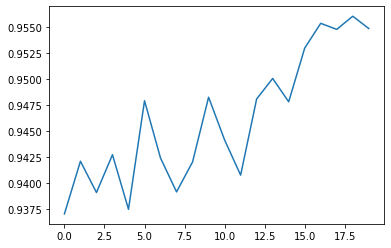

In [ ]:
plt.plot([auc.numpy() for auc in train_auc_history])

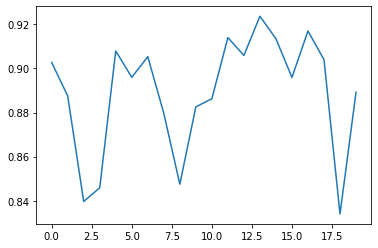

In [ ]:
plt.plot([auc.numpy() for auc in val_auc_history])